# 1 Import Dataset

In [ ]:
#### IMPORTS ####
import pandas as pd # for data manipulation and .describe()

# #### READ IN DATA ####
cov = pd.read_csv("datasets/latestdata.csv") # original (can be switched out for smaller or outcome to run quicker)

# Inspect data
print(cov.count()) # print(cov["sex"].describe() # also good



# 2 Data Preparation

## 2.1 Drop irrelevant columns and rows

In [ ]:
#### SELECT ONLY THE RELEVANT COLUMNS ####
# Interesting problems which don't have quite enough data
# fields = ["age", "sex", "outcome", "date_admission_hospital", "date_onset_symptoms", "country"] # 228 rows
# fields = ["outcome", "date_admission_hospital", "date_onset_symptoms"] # 234 rows
# fields = ["outcome", "date_admission_hospital", "date_confirmation"] # 262 rows
# fields = ["outcome", "date_confirmation", "date_onset_symptoms"] # 3505 rows

# Identify the columns required for the problem
fields = ["outcome", "age", "sex", "date_confirmation", "date_onset_symptoms", "country"] # 3493 rows - mostly from the phillipines
# Without the dates - worth having a look into
# fields = ["outcome", "country", "age", "sex"] # 33599 rows

# Select these columns from the dataset
dataset = cov[fields]

#### DATA CLEANING ####
 
# Drop the rows which are missing information
dataset = dataset.dropna(subset=fields)

# Store the set for future use
dataset.to_csv("datasets/dataset1.csv")
print('stored dataset')

In [2]:
# Instead of doing the above steps you can load the processed dataset
import pandas as pd
dataset = pd.read_csv('datasets/dataset1.csv')
print('read dataset from dataset1.csv')
# Drop the unnamed column
dataset = dataset.drop(columns=['Unnamed: 0'])

read dataset from dataset1.csv


## 2.2 Feature encoding

In [3]:
# Tidy the outcome column
dataset = dataset.replace(to_replace={'outcome': {
    'died':0,
    'death':0,
    'Deceased':0,
    'dead':0,
    'stable':1,
    'treated in an intensive care unit (14.02.2020)':1,
    'Symptoms only improved with cough. Currently hospitalized for follow-up.':1, # TODO drop and compare results
    'severe':0,        
    'Hospitalized':1, # TODO drop and compare
    'discharge':1,
    'discharged':1,
    'Discharged':1,
    'Alive':1,
    'recovered':1,
    }})

# print(dataset['age'].head)

# Tidy the ages column # TODO these need feature scaling
dataset = dataset.replace(to_replace={'age': {
    '0-9':5,
    '10-19':15,
    '20-29':25,
    '30-39':35,
    '40-49':45,
    '50-59':55,
    '60-69':65,
    '70-79':75,
    '80-89':85,
    '90-99':95,
    }}, regex=True)
# age_df = pd.get_dummies(dataset['age'])

# Apply feature scaling to the ages
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
dataset[['age']] = scaler.fit_transform(dataset[['age']])
# print(dataset['age'].head)

# Replace the two dates columns with days_waiting
gaps = []
from datetime import date, datetime, timedelta
for i in range(len(dataset['date_confirmation'])):
    dataset['date_confirmation'][i] = datetime.strptime(dataset['date_confirmation'][i], r'%d.%m.%Y')
    dataset['date_onset_symptoms'][i] = datetime.strptime(dataset['date_onset_symptoms'][i], r'%d.%m.%Y')
    gaps.append(dataset['date_confirmation'][i] - dataset['date_onset_symptoms'][i])

dataset['days_waiting'] = gaps
dataset = dataset.drop(columns=['date_confirmation', 'date_onset_symptoms'])
dataset['days_waiting'] = dataset['days_waiting'].dt.days
dataset = dataset[dataset['days_waiting'] >= 0]

# Encode the sex data as integers
dataset = dataset.replace(to_replace={'sex': {
    'male':0,
    'female':1
}})

# Encode the country data using one hot encoding
countries_df = pd.get_dummies(dataset['country'])
dataset = pd.concat([dataset, countries_df], axis=1)
dataset = dataset.drop(columns=['country'])

# Save the cleaned up dataset for future use
dataset.to_csv('datasets/dataset1_clean.csv')

/home/sam/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/sam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## 2.3 Reweighting

# 3 Visualisation

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(20,5))

data = dataset['age']
sns.histplot(data=data, ax=ax[0])

data = dataset.loc[dataset['outcome'] == 0, 'age']
sns.histplot(data=data, ax=ax[1]).set_title('Died')
data = dataset.loc[dataset['outcome'] == 1, 'age']
sns.histplot(data=data, ax=ax[2]).set_title('Recovered')


Text(0.5,1,'Recovered')

Text(0.5,1,'Recovered')

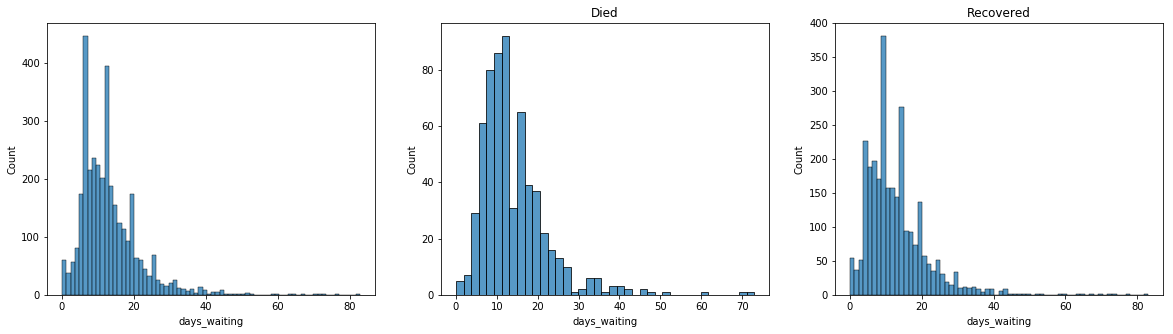

In [5]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

data = dataset['days_waiting']
sns.histplot(data=data, ax=ax[0])

data = dataset.loc[dataset['outcome'] == 0, 'days_waiting']
sns.histplot(data=data, ax=ax[1]).set_title('Died')
data = dataset.loc[dataset['outcome'] == 1, 'days_waiting']
sns.histplot(data=data, ax=ax[2]).set_title('Recovered')

# 4 Model Training

## 4.1 Split the dataset into features/labels and test/train

In [6]:
# Split the data into features and labels
features = dataset.drop(['outcome'], axis=1)
labels = dataset['outcome']

# print('features\n', features.value_counts())
# print('labels\n', labels.value_counts())

# Split the data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=0) # This also shuffles the data

## 4.2 Fit the models

In [7]:
# Import and fit a Support Vector Machine
from sklearn import svm
svm_classifier = svm.SVC(gamma='auto', class_weight={0: 2832/624, 1:1})
svm_classifier.fit(X_train, y_train)

# Immport and fit a logistic regression model
from sklearn import linear_model
# LR_classifier = linear_model.LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000) # MULTINOMIAL There are five solvers that can be used to obtain the weights 
LR_classifier = linear_model.LogisticRegression(solver='lbfgs', max_iter=1000, class_weight={0: 2832/624, 1:1})
LR_classifier.fit(X_train, y_train)

# Import and fit a decision tree
from sklearn import tree
tree_classifier = tree.DecisionTreeClassifier(class_weight={0: 2832/624, 1:1})
tree_classifier.fit(X_train, y_train)

# Import a random forest
from sklearn.ensemble import RandomForestClassifier
forest_classifier = RandomForestClassifier(class_weight={0: 2832/624, 1:1})
forest_classifier.fit(X_train, y_train)

# Import and fit a naive bayes model
from sklearn.naive_bayes import GaussianNB
# from sklearn.naive_bayes import MultinomialNB
nb_classifier = GaussianNB()
# nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# # import and fit an XGboost model
import xgboost as xgb
xgb_classifier = xgb.XGBClassifier()#use_label_encoder=False)
xgb_classifier.fit(X_train, y_train)

/home/sam/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/sam/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[10:38:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=100, n_jobs=8, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       use_label_encoder=True, validate_parameters=1, verbosity=None)

# 5 Model Evaluation

## 5.1 Use the models to make some predictions

In [8]:
# Make predictions on the test dataset with each model
svm_predictions = svm_classifier.predict(X_test)
LR_predictions = LR_classifier.predict(X_test)
tree_predictions = tree_classifier.predict(X_test)
forest_predictions = forest_classifier.predict(X_test)
nb_predictions = nb_classifier.predict(X_test)
xgb_predictions = xgb_classifier.predict(X_test)




## 5.2 Measure the accuracy of the predictions

In [10]:
# Measure the accuracy of each set of predictions
from sklearn import metrics
svm_accuracy = metrics.accuracy_score(y_test, svm_predictions)
LR_accuracy = metrics.accuracy_score(y_test, LR_predictions)
tree_accuracy = metrics.accuracy_score(y_test, tree_predictions)
forest_accuracy = metrics.accuracy_score(y_test, forest_predictions)
nb_accuracy = metrics.accuracy_score(y_test, nb_predictions)
xgb_accuracy = metrics.accuracy_score(y_test, xgb_predictions)

print(f'SVM score: {svm_accuracy}\nLR score: {LR_accuracy}\nTree score: {tree_accuracy}\nForest score: {forest_accuracy}\nNaive Bayes score: {nb_accuracy}\nXGB score: {xgb_accuracy}')


SVM score: 0.7196531791907514
LR score: 0.7225433526011561
Tree score: 0.7225433526011561
Forest score: 0.7658959537572254
Naive Bayes score: 0.2543352601156069
XGB score: 0.8294797687861272


## 5.3 Produce a more detailed report

In [11]:
# Produce classification reports

# precision = % of Positives that are correct and recall = % of negatives that are found)
# The recall for a class is the sensitivity to that class (if it exists is it identified)
# The precision for a class is the 

print(f'Confusion matrix for svm (0:died, 1:recovered):')
print(metrics.confusion_matrix(y_test, svm_predictions))
print(f'Classification report for svm (0:died, 1:recovered):')
print(metrics.classification_report(y_test, svm_predictions, target_names=['died','recovered']))

print(f'Classification report for Logistic Regression (0:died, 1:recovered):')
print(metrics.classification_report(y_test, LR_predictions, target_names=['died','recovered'])[:166])

print(f'Classification report for Decision Tree (0:died, 1:recovered):')
print(metrics.classification_report(y_test, tree_predictions, target_names=['died','recovered'])[:166])

print(f'Classification report for Random Forest (0:died, 1:recovered):')
print(metrics.classification_report(y_test, forest_predictions, target_names=['died','recovered'])[:166])

print(f'Classification report for Naive Bayes (0:died, 1:recovered):')
print(metrics.classification_report(y_test, nb_predictions, target_names=['died','recovered'])[:166])

print(f'Classification report for XGBoost (0:died, 1:recovered):')
print(metrics.classification_report(y_test, xgb_predictions, target_names=['died','recovered'])[:166])





Confusion matrix for svm (0:died, 1:recovered):
[[ 52  18]
 [ 79 197]]
Classification report for svm (0:died, 1:recovered):
              precision    recall  f1-score   support

        died       0.40      0.74      0.52        70
   recovered       0.92      0.71      0.80       276

   micro avg       0.72      0.72      0.72       346
   macro avg       0.66      0.73      0.66       346
weighted avg       0.81      0.72      0.74       346

Classification report for Logistic Regression (0:died, 1:recovered):
              precision    recall  f1-score   support

        died       0.40      0.74      0.52        70
   recovered       0.92      0.72      0.80       276

  
Classification report for Decision Tree (0:died, 1:recovered):
              precision    recall  f1-score   support

        died       0.37      0.54      0.44        70
   recovered       0.87      0.77      0.82       276

  
Classification report for Random Forest (0:died, 1:recovered):
              precis

# TODO LIST
* [] make a few plots such as age/country and days waiting
* [] k-fold cross validation
* [] pick 3 models
* [] Research the encodings each model takes
* [] Tune the model parameters